# user profiling

In [ ]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
from collections import defaultdict
import random
import seaborn as sns

In [ ]:
path_results = 'your_path'
path_inputs = 'your_path'
# print(os.listdir(path_results))
# print(os.listdir(path_inputs))

# **CREATING THE user app usage vector**

We generated 1000 synthetic users using the law-power distribution inter and intra-category.
1. We assigned the categories and weight per categories to each user.
2. We assigned an app per category.

The probabilities inter-category are stored in the file: *probs_inter_category.csv* (the probability assigned to each category is the probility of installing an app from that category) and the probabilities intra-category are stored in the file: *probs_intra_category.csv* (the probability of installation of each app in its respective category).

We stored all users app usage vectors in a CSV file called *user_profiles.csv*.





In [ ]:
categories = []
with open(os.path.join(path_inputs,'probs_inter_category.csv'), 'r', newline='', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        cat = row["Category"]
        perc = float(row["GlobalPercentage"])
        categories.append((cat, perc))

cat_names = [c[0] for c in categories]
cat_probs = [c[1] for c in categories]  # Suman aproximadamente 100
cat_probs_normalized = [p / 100.0 for p in cat_probs]  # Normalizamos a [0,1]

apps_by_category = {}
with open(os.path.join(path_inputs,'probs_intra_category.csv'), 'r', newline='', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        cat = row["Category"]
        app_name = row["AppName"]
        app_pct = float(row["AppPercentage"])

        if cat not in apps_by_category:
            apps_by_category[cat] = []
        apps_by_category[cat].append((app_name, app_pct))

apps_and_category_normalized = {}
for cat, apps_list in apps_by_category.items():
    total = sum(a[1] for a in apps_list)
    apps_probs = [a[1]/total for a in apps_list]

    joined_list = []
    for (app_name, raw_pct), prob in zip(apps_list, apps_probs):
        joined_list.append((app_name, raw_pct, prob))
    apps_and_category_normalized[cat] = joined_list

num_users = 1000

all_users_categories_distribution = []
all_users_profiles = []

for user_idx in range(num_users):
    categories_distribution = np.random.multinomial(100, cat_probs_normalized)
    all_users_categories_distribution.append(categories_distribution)

    user_dict = {}

    for i, category_portion in enumerate(categories_distribution):
        category_name = cat_names[i]

        if category_portion == 0:
            user_dict[category_name] = ("", 0)
        else:
            apps_normalized_list = apps_and_category_normalized[category_name]
            chosen_app = random.choices(
                apps_normalized_list,
                weights=[item[2] for item in apps_normalized_list],
                k=1
            )[0]

            app_name = chosen_app[0]
            user_dict[category_name] = (app_name, category_portion)

    all_users_profiles.append(user_dict)

with open(os.path.join(path_results,'user_app_usage_vectors.csv'), 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(["User", "Category", "AppName", "AppPercentage"])

    for user_idx, user_dict in enumerate(all_users_profiles):
        user_name = f"user {user_idx+1}"

        for cat in cat_names:
            app_name, portion = user_dict[cat]
            writer.writerow([user_name, cat, app_name, portion])

print("Se ha creado el CSV con los perfiles de usuarios")


Se ha creado el CSV con los perfiles de usuarios


In [ ]:
all_users_profiles

[{'SOCIAL': ('facebook', np.int64(61)),
  'COMMUNICATION': ('messenger', np.int64(16)),
  'BUSINESS': ('jobway', np.int64(9)),
  'MUSIC_AND_AUDIO': ('starmarker', np.int64(5)),
  'GAMES': ('freefire', np.int64(7)),
  'ENTERTAINMENT': ('twitch', np.int64(1)),
  'SHOPPING': ('lazada', np.int64(1)),
  'BOOKS_AND_REFERENCE': ('', 0),
  'NEWS_AND_MAGAZINES': ('', 0),
  'EDUCATION': ('', 0)},
 {'SOCIAL': ('likee_lite', np.int64(59)),
  'COMMUNICATION': ('messenger', np.int64(14)),
  'BUSINESS': ('zoom', np.int64(12)),
  'MUSIC_AND_AUDIO': ('spotify', np.int64(3)),
  'GAMES': ('freefire', np.int64(8)),
  'ENTERTAINMENT': ('dubsmash', np.int64(1)),
  'SHOPPING': ('', 0),
  'BOOKS_AND_REFERENCE': ('wikipedia', np.int64(2)),
  'NEWS_AND_MAGAZINES': ('podcast_player', np.int64(1)),
  'EDUCATION': ('', 0)},
 {'SOCIAL': ('facebook', np.int64(58)),
  'COMMUNICATION': ('messenger', np.int64(14)),
  'BUSINESS': ('jobway', np.int64(8)),
  'MUSIC_AND_AUDIO': ('zing3', np.int64(8)),
  'GAMES': ('freefire

## reading the users from the user_app_usage_vectors file:

In [ ]:
def read_user_profiles_vectors(user_profiles_path):
    users = {}

    with open(user_profiles_path, 'r', newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            usr = row["User"]
            cat = row["Category"]
            app = row["AppName"]
            pct = float(row["AppPercentage"])

            if usr not in users:
                users[usr] = []

            users[usr].append((cat, app, pct))

    return users

## read the cat_names

In [ ]:
def get_cat_names(file_path):
    categories = []

    with open(file_path, 'r', newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            cat = row["Category"]
            perc = float(row["GlobalPercentage"])
            categories.append((cat, perc))

    cat_names = [c[0] for c in categories]

    return cat_names

# **CREATING THE USERS FILES: "synthetic_traces_per_user"**

Based on the user_app_usage_vectors.csv we assign the traffic to each user.
* The traffic that we use to create the synthetic users is already in csv format (in the file *entire_dataset_continuous.csv*).
* The traffic assigned to each user is stored in a CSV per user. It is stored in the folder: *synthetic_traces_per_user*


In [ ]:
input_file = os.path.join(path_inputs, "entire_dataset_continuous.csv")

app_queries = {}
with open(input_file, 'r', newline='', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        # "Category", "App", "PCAP", "Timestamp", "Domain", "NewTS"
        app = row["App"]
        if app not in app_queries:
            app_queries[app] = []
        app_queries[app].append(row)

# (Optional) Print a few records to verify.
for app, records in app_queries.items():
    print(f"App: {app}, number of records: {len(records)}")
    print("First record:", records[0])
    break  # Remove break to print for all apps if desired.


App: among_us, number of records: 1792
First record: {'Category': 'GAME_ACTION', 'App': 'among_us', 'PCAP': 'amongus_1_20m_2pm_11032021.pcap.csv', 'Timestamp': '1615433377.882702', 'Domain': 'www.google.com.', 'NewTS': '0'}


In [ ]:
users_vector = read_user_profiles_vectors(os.path.join(path_results, "user_app_usage_vectors.csv"))
# users_vector.items()

## extract the time window

In [ ]:
def extract_time_window_for_app(app_data, minutes_needed, tolerance_seconds=300):

    if minutes_needed <= 0:
        return []
    if len(app_data) < 2:
        return []

    needed_seconds = minutes_needed * 60
    start_index = 0
    start_ts = int(float(app_data[start_index]["NewTS"]))
    end_ts = start_ts + needed_seconds

    window_indices = []
    i = start_index
    while i < len(app_data):
        current_ts = int(float(app_data[i]["NewTS"]))
        if current_ts <= end_ts:
            window_indices.append(i)
            i += 1
        else:
            break

    if window_indices:
        ts_first = int(float(app_data[window_indices[0]]["NewTS"]))
        ts_last = int(float(app_data[window_indices[-1]]["NewTS"]))
        time_span = ts_last - ts_first

        if abs(time_span - needed_seconds) <= tolerance_seconds:   # check if the window's span is within the torence_seconds+needed_seconds
            return [app_data[idx] for idx in window_indices]

    return []

## main loop

We assign a total time of 100 minutes per user.

For each user, we calculate the minutes from each app based on the percentage.

In [ ]:
users_vector = read_user_profiles_vectors(os.path.join(path_results, "user_app_usage_vectors.csv"))
users_profiles_queries_dir = os.path.join(path_results, "synthetic_traces_per_user")
os.makedirs(users_profiles_queries_dir, exist_ok=True)

total_time_per_user = 100  # 100min for each user

for user, apps in users_vector.items():
    user_file_path = os.path.join(users_profiles_queries_dir, f"user_{user}.csv")

    with open(user_file_path, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['Category', 'App', 'PCAP', 'Timestamp', 'DNS domains'])

        print(f"Processing {user} ...")

        for cat, app, pct in apps:
            minutes_for_app = int((total_time_per_user * pct) / 100.0)

            if app not in app_queries or not app_queries[app]:
                print(f"  -> No data left for app {app} or app not found. Skipping.")
                continue

            assigned_lines = extract_time_window_for_app(app_queries[app], minutes_for_app, tolerance_seconds=700)

            if not assigned_lines:
                print(f"  -> Could not assign a {minutes_for_app}-min window for app {app}. Skipping.")
                continue

            for q in assigned_lines:
                writer.writerow([
                    q['Category'],
                    q['App'],
                    q['PCAP'],
                    q['Timestamp'],
                    q['Domain']
                ])

            print(f"  -> Assigned {len(assigned_lines)} lines for {app} corresponding to ~{minutes_for_app} min.")



Streaming output truncated to the last 5000 lines.
  -> Assigned 24 lines for among_us corresponding to ~7 min.
  -> Assigned 6 lines for twitch corresponding to ~1 min.
  -> Assigned 105 lines for lazada corresponding to ~1 min.
  -> Assigned 28 lines for mangatoon corresponding to ~1 min.
  -> No data left for app  or app not found. Skipping.
  -> No data left for app  or app not found. Skipping.
Processing user 547 ...
  -> Assigned 186 lines for instagram corresponding to ~57 min.
  -> Assigned 87 lines for messenger corresponding to ~22 min.
  -> Assigned 19 lines for zoom corresponding to ~9 min.
  -> Assigned 7 lines for spotify corresponding to ~8 min.
  -> Assigned 11 lines for freefire corresponding to ~3 min.
  -> Assigned 28 lines for nimo corresponding to ~1 min.
  -> No data left for app  or app not found. Skipping.
  -> No data left for app  or app not found. Skipping.
  -> No data left for app  or app not found. Skipping.
  -> No data left for app  or app not found. Ski

# User Profiling: (user DNS profiling vector) percentage of traffic DNS per user.

Based on the generation of sintetic users, we have a time window of 100 minutes per user where we assign a percentage of traffic of each app per category.

In [ ]:
cat_names = get_cat_names(os.path.join(path_inputs,'probs_inter_category.csv'))

results = []

for filename in sorted(os.listdir(os.path.join(path_results, "synthetic_traces_per_user"))):
    if filename.endswith(".csv"):
        filepath = os.path.join(os.path.join(path_results, "synthetic_traces_per_user"), filename)
        df = pd.read_csv(filepath)
        total_dns = len(df)

        grouped = df.groupby(["Category", "App"]).size().reset_index(name="Count")  # count the domains per app/category

        for cat in cat_names:
            cat_group = grouped[grouped["Category"] == cat]
            if not cat_group.empty:
                apps = "/".join(cat_group["App"].unique())
                count_sum = cat_group["Count"].sum()
                percentage = (count_sum / total_dns) * 100
            else:
                apps = ""
                percentage = 0

            user_key = os.path.splitext(filename)[0]
            results.append({
                "User": user_key,
                "Category": cat,
                "AppName": apps,
                "AppPercentage": percentage
            })

result_df = pd.DataFrame(results)[["User", "Category", "AppName", "AppPercentage"]]

output_csv = os.path.join(path_results, "user_DNS_profiling.csv")
result_df.to_csv(output_csv, index=False)
print(f"CSV saved as {output_csv}")

,User,Category,AppName,AppPercentage
0,user_user 1,SOCIAL,facebook,29.695024
1,user_user 1,COMMUNICATION,google_meet,21.990369
2,user_user 1,BUSINESS,jobway,21.990369
3,user_user 1,MUSIC_AND_AUDIO,spotify,0.963082
4,user_user 1,GAMES,among_us,2.086677
...,...,...,...,...
9995,user_user 999,ENTERTAINMENT,dubsmash,6.183369
9996,user_user 999,SHOPPING,,0.000000
9997,user_user 999,BOOKS_AND_REFERENCE,,0.000000
9998,user_user 999,NEWS_AND_MAGAZINES,,0.000000


## Histograms of User Profiling: percentage of traffic DNS per user.

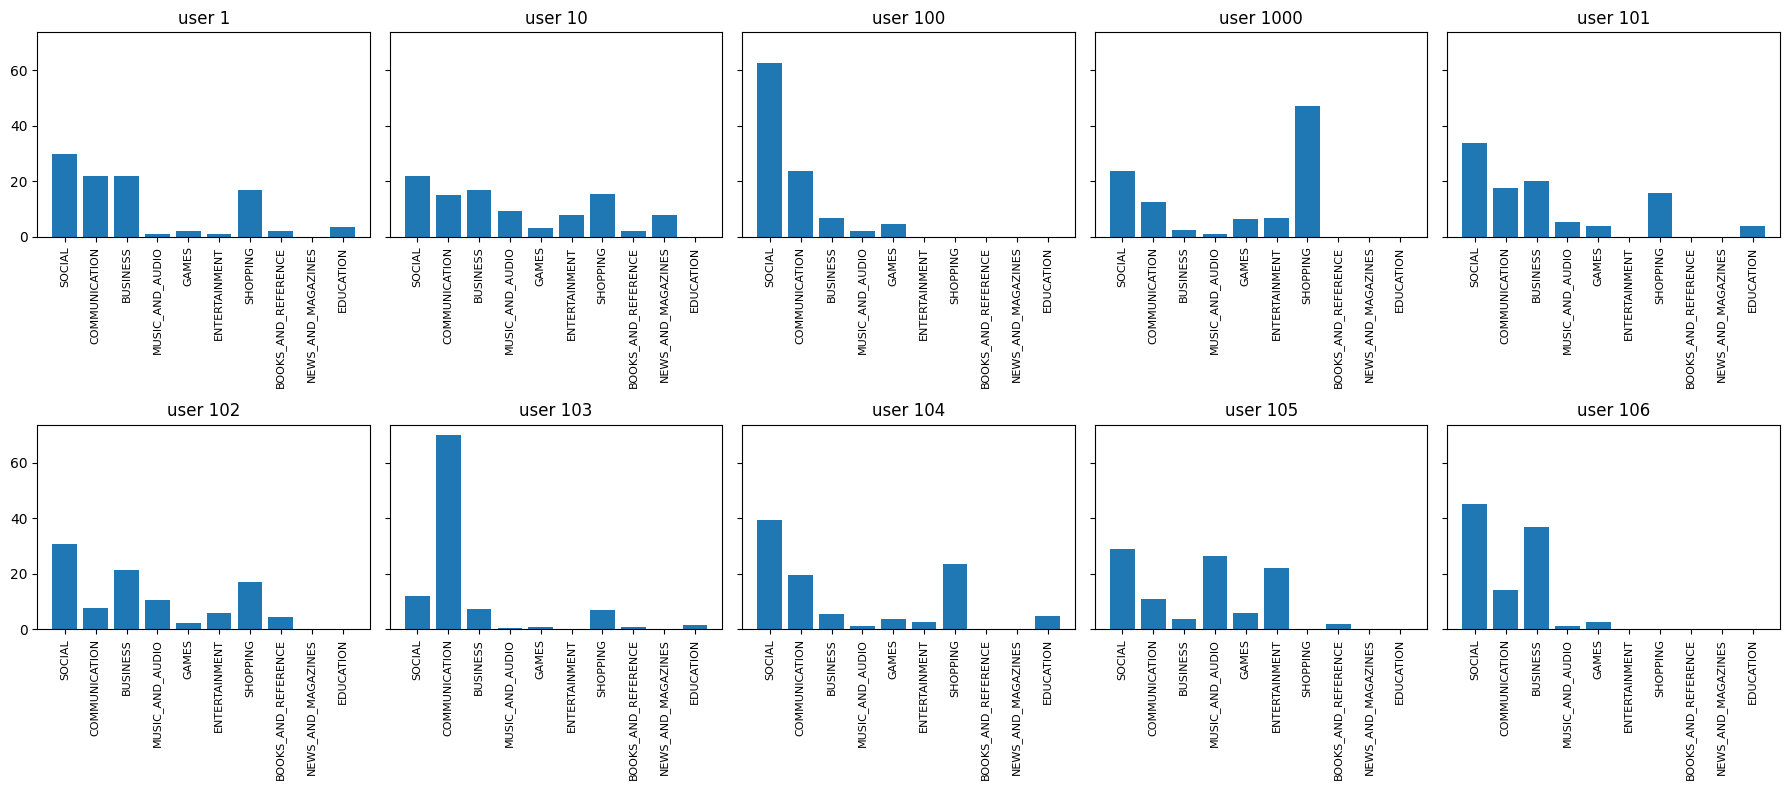

In [ ]:
# convert it into dictionary to plot it easily
result_df = pd.read_csv(os.path.join(path_results, "user_DNS_profiling.csv"))

result_dict = {}

for pcap, group in result_df.groupby("User"):
    user_key = pcap.replace("user_", "").replace(".csv", "")

    tuples_list = []
    for _, row in group.iterrows():
        app = row["AppName"]
        if pd.isna(app):
            app = ""
        tup = (row["Category"], app, row["AppPercentage"])
        tuples_list.append(tup)

    result_dict[user_key] = tuples_list

cat_names = get_cat_names(os.path.join(path_inputs,'probs_inter_category.csv'))

# histograms
selected_user_keys = list(result_dict.keys())[:10]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 8), sharey=True)
axes = axes.flatten()

for i, user_key in enumerate(selected_user_keys):
    ax = axes[i]

    user_data = result_dict[user_key]

    cat2pct = {}
    for (cat, app, pct) in user_data:
        cat2pct[cat] = pct

    cat_dist = [cat2pct.get(cat, 0) for cat in cat_names]

    ax.bar(cat_names, cat_dist)
    ax.set_title(f"{user_key}")

    ax.set_xticks(range(len(cat_names)))
    ax.set_xticklabels(cat_names, rotation=90, fontsize=8)

plt.tight_layout()

# plt.savefig(os.path.join(path_figures,"example_userprofiling_10users_by_percentage_DNStraffic_new_categories_all_correct.png"), dpi=300, bbox_inches='tight')#user_profiling_by_percentage_DNStraffic_new_categories
plt.show()

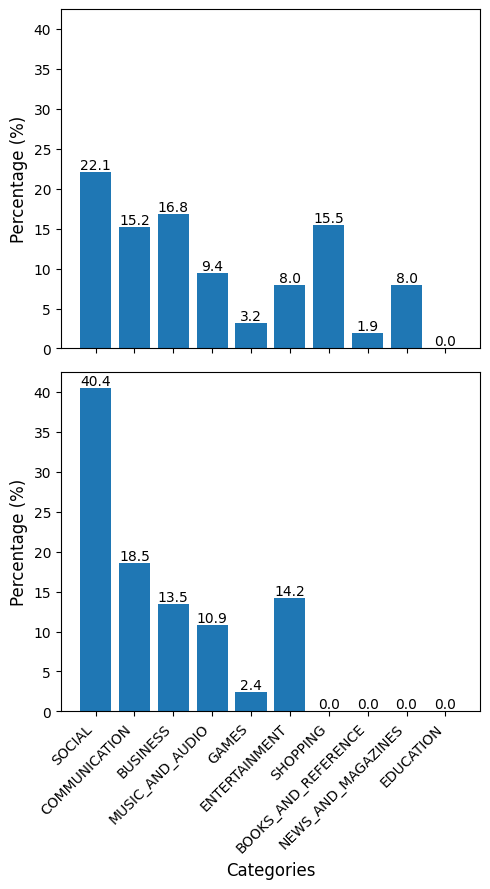

In [ ]:
result_df = pd.read_csv(os.path.join(path_results, "user_DNS_profiling.csv"))

result_dict = {}
for pcap, group in result_df.groupby("User"):
    user_key = pcap.replace("user_", "").replace(".csv", "")
    tuples_list = []
    for _, row in group.iterrows():
        app = row["AppName"]
        if pd.isna(app):
            app = ""
        tup = (row["Category"], app, row["AppPercentage"])
        tuples_list.append(tup)
    result_dict[user_key] = tuples_list

cat_names = get_cat_names(os.path.join(path_inputs,'probs_inter_category.csv'))

selected_user_keys = ['user 10', 'user 109'] # select the users to plot

fig, axes = plt.subplots(nrows=len(selected_user_keys), ncols=1, figsize=(5,9), sharey=True)
if len(selected_user_keys) == 1:
    axes = [axes]

for i, user_key in enumerate(selected_user_keys):
    ax = axes[i]
    user_data = result_dict.get(user_key, [])
    cat2pct = {}
    for (cat, app, pct) in user_data:
        cat2pct[cat] = pct
    cat_dist = [cat2pct.get(cat, 0) for cat in cat_names]

    bars = ax.bar(cat_names, cat_dist)
    if i != len(selected_user_keys) - 1:
        ax.tick_params(labelbottom=False)
    else:
        ax.set_xticks(range(len(cat_names)))
        ax.set_xticklabels(cat_names, rotation=45, ha='right', fontsize=10)
        ax.set_xlabel("Categories", fontsize=12)
    ax.set_ylabel("Percentage (%)", fontsize=12)

    # Loop over the bars to add the text labels.
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height:.1f}',
            ha='center',
            va='bottom',
            fontsize=10,
            color='black'
        )

plt.tight_layout()
# plt.savefig(os.path.join(path_figures, "example_2_userprofiling_selected_users_by_percentage_DNStraffic_corrected.pdf"), dpi=300, bbox_inches='tight')
plt.show()


## boxplot to see the variability of the user_DNS_profiling.csv

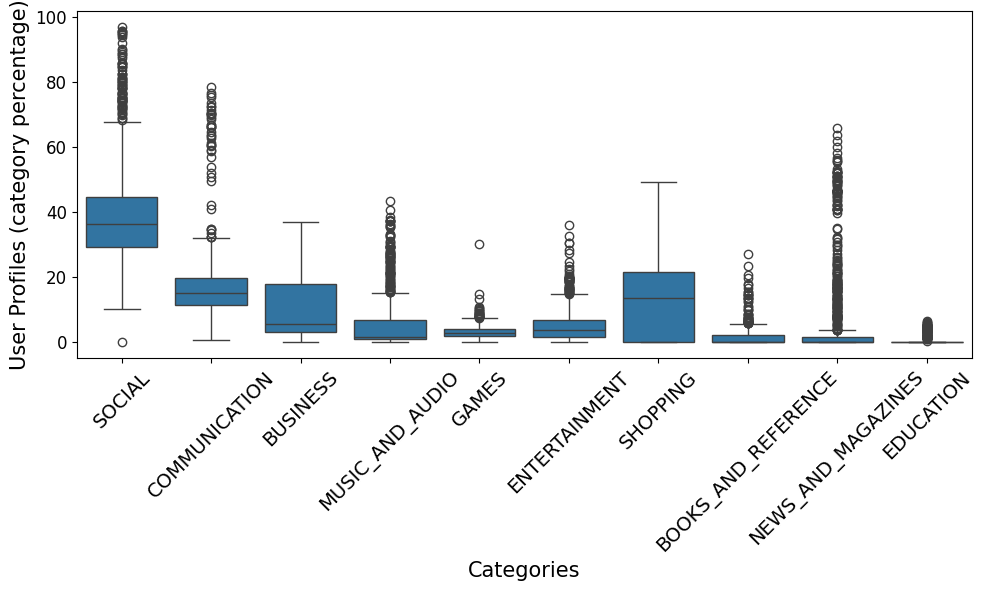

In [ ]:
df = result_df[["User","Category","AppPercentage"]]

cat_names = get_cat_names(os.path.join(path_inputs,'probs_inter_category.csv'))

plt.figure(figsize=(10, 6))
sns.boxplot(x="Category", y="AppPercentage", data=df, order=cat_names)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel("User Profiles (category percentage)",fontsize=15)
plt.xlabel("Categories",fontsize=15)
plt.tight_layout()
# plt.savefig(os.path.join(path_figures,"boxp_user_profiling_by_percentage_DNStraffic_new_categories_all_correct.pdf"), dpi=300, bbox_inches='tight')
plt.show()


# Graphs and figures

## pie chart

Selected users: ['user_user 106', 'user_user 109']


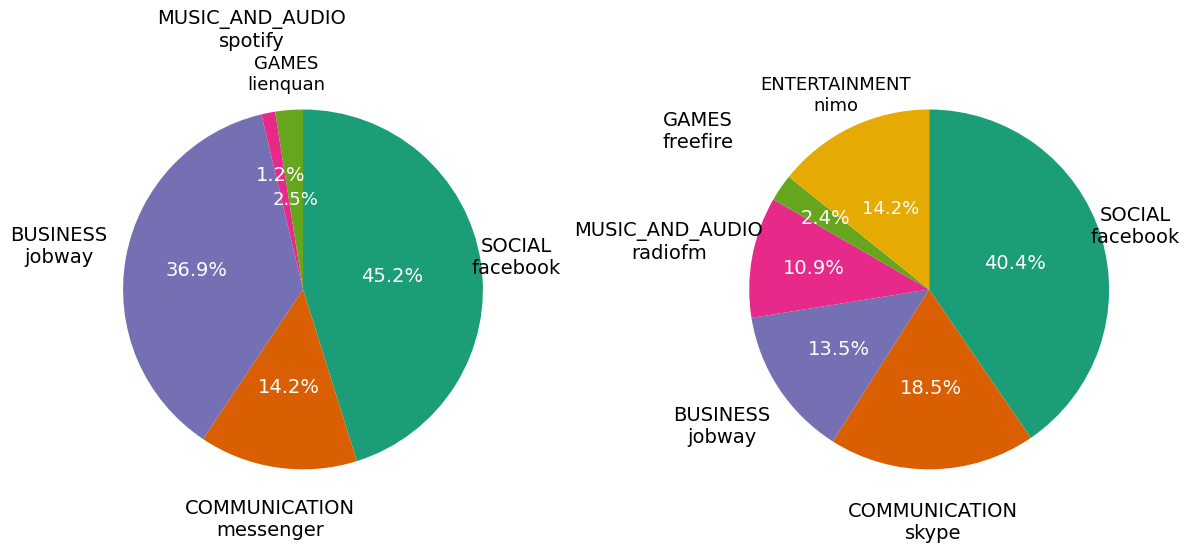

In [ ]:
ordered_categories = [
    "SOCIAL",
    "COMMUNICATION",
    "BUSINESS",
    "MUSIC_AND_AUDIO",
    "GAMES",
    "ENTERTAINMENT",
    "SHOPPING",
    "BOOKS_AND_REFERENCE",
    "NEWS_AND_MAGAZINES",
    "EDUCATION"
]

csv_file = os.path.join(path_results, "user_DNS_profiling.csv")
df = pd.read_csv(csv_file)

user_nonzero_counts = df[df['AppPercentage'] > 0].groupby('User').size()

filtered_users = user_nonzero_counts[user_nonzero_counts < 7].index.tolist() # users with less than 7 categories with nonzero AppPercentage

selected_users = filtered_users[1:3] # select the users to plot
print("Selected users:", selected_users)

user_data = {}
for user in selected_users:
    user_df = df[df['User'] == user]
    cat_dict = {cat: {"Percentage": 0, "App": ""} for cat in ordered_categories}
    for _, row in user_df.iterrows():
        cat = row["Category"]
        if cat in cat_dict:
            cat_dict[cat] = {"Percentage": row["AppPercentage"], "App": row["AppName"]}
    user_data[user] = cat_dict

num_selected = len(selected_users)
fig, axes = plt.subplots(nrows=1, ncols=num_selected, figsize=(6*num_selected, 6))

if num_selected == 1:
    axes = [axes]

cmap = plt.get_cmap('Dark2', 8)
color_mapping = {
    "SOCIAL": cmap(0),
    "COMMUNICATION": cmap(1),
    "BUSINESS": cmap(2),
    "MUSIC_AND_AUDIO": cmap(3),
    "GAMES": cmap(4),
    "ENTERTAINMENT": cmap(5),
    "SHOPPING": cmap(6),
    "BOOKS_AND_REFERENCE": cmap(7),
    "NEWS_AND_MAGAZINES": cmap(0),
    "EDUCATION": cmap(1)
}


for ax, user in zip(axes, selected_users):
    cat_dict = user_data[user]

    percentages = []
    labels = []
    cats = []
    for cat in ordered_categories:
        pct = cat_dict[cat]["Percentage"]
        if pct > 0:
            percentages.append(pct)
            labels.append(f"{cat}\n{cat_dict[cat]['App']}")
            cats.append(cat)

    if percentages:

        colors = [color_mapping[cat] for cat in cats]
        wedges, _ = ax.pie(percentages, labels=None, startangle=90, counterclock=False, colors=colors)

        custom_labeldistances = [1.2 + 0.09*i for i in range(len(percentages))]
        custom_pctdistances   = [0.5 + 0.05*i for i in range(len(percentages))]

        for i, wedge in enumerate(wedges):
          ang = np.deg2rad((wedge.theta2 + wedge.theta1) / 2)
          x, y = np.cos(ang), np.sin(ang)
          if i == len(wedges) - 1:
              ax.text(custom_labeldistances[i-len(wedges)+1] * x, custom_labeldistances[i-len(wedges)+1] * y, labels[i],
                      ha='center', va='center', fontsize=13)
              ax.text(custom_pctdistances[i-len(wedges)+1]* x, custom_pctdistances[i-len(wedges)+1] * y, f'{percentages[i]:.1f}%',
                      ha='center', va='center', fontsize=13, color='white')
          else:
              ax.text(custom_labeldistances[i] * x, custom_labeldistances[i] * y,
                      labels[i], ha='center', va='center', fontsize=14)
              ax.text(custom_pctdistances[i] * x, custom_pctdistances[i] * y,
                      f'{percentages[i]:.1f}%', ha='center', va='center', fontsize=14, color='white')

    else:
        ax.text(0.5, 0.5, "No Data", ha="center", va="center")

plt.tight_layout()
# plt.savefig(os.path.join(path_figures,"piechart_user_profiles_new_categories_all_correct_2.pdf"), dpi=300, bbox_inches='tight') #user_profiling_by_percentage_DNStraffic_new_categories_all_correct_2
plt.show()


### latex interpreter

In [ ]:
!apt-get update
!apt-get install -y texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,767 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,692 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3

Selected users: ['user_user 106', 'user_user 109']


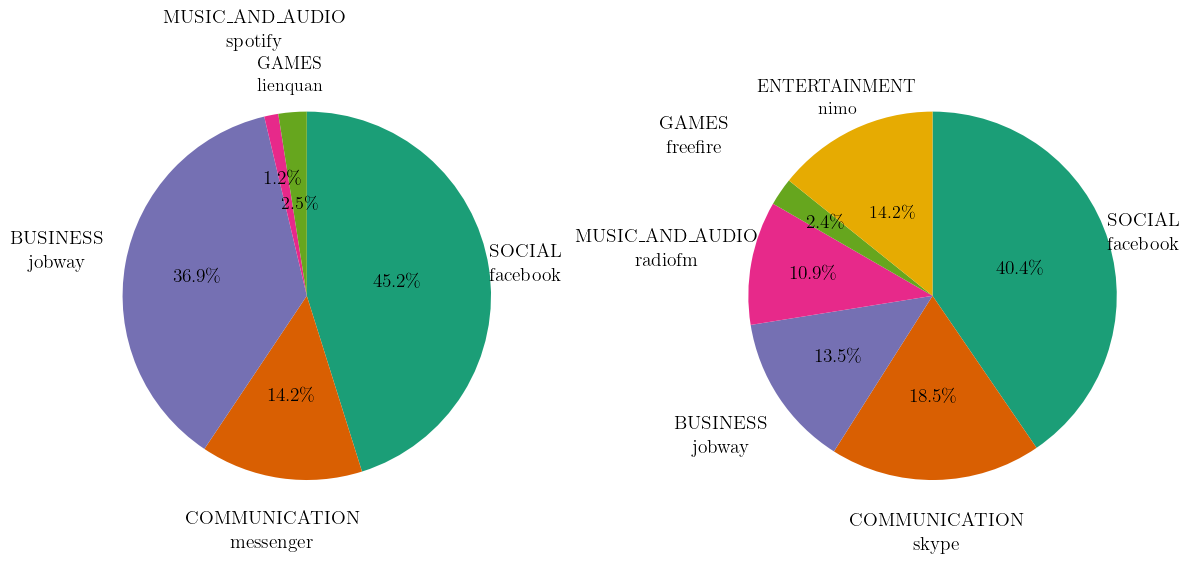

In [ ]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

ordered_categories = [
    "SOCIAL",
    "COMMUNICATION",
    "BUSINESS",
    "MUSIC\_AND\_AUDIO",
    "GAMES",
    "ENTERTAINMENT",
    "SHOPPING",
    "BOOKS\_AND\_REFERENCE",
    "NEWS\_AND\_MAGAZINES",
    "EDUCATION"
]

csv_file = os.path.join(path_results, "user_DNS_profiling.csv")
df = pd.read_csv(csv_file)

user_nonzero_counts = df[df['AppPercentage'] > 0].groupby('User').size()

filtered_users = user_nonzero_counts[user_nonzero_counts < 7].index.tolist() # users with less than 7 categories with nonzero AppPercentage

selected_users = filtered_users[1:3] # select the users to plot
print("Selected users:", selected_users)

user_data = {}
for user in selected_users:
    user_df = df[df['User'] == user]
    cat_dict = {cat: {"Percentage": 0, "App": ""} for cat in ordered_categories}
    for _, row in user_df.iterrows():
        cat = row["Category"].replace("_", r"\_")
        if cat in cat_dict:
            cat_dict[cat] = {"Percentage": row["AppPercentage"], "App": row["AppName"]}
    user_data[user] = cat_dict

def latex_label(category, app):
    return rf"\begin{{tabular}}{{c}} {category} \\ {app} \end{{tabular}}"

num_selected = len(selected_users)
fig, axes = plt.subplots(nrows=1, ncols=num_selected, figsize=(6*num_selected, 6))

if num_selected == 1:
    axes = [axes]

cmap = plt.get_cmap('Dark2', 8)
color_mapping = {
    "SOCIAL": cmap(0),
    "COMMUNICATION": cmap(1),
    "BUSINESS": cmap(2),
    "MUSIC\\_AND\\_AUDIO": cmap(3),
    "GAMES": cmap(4),
    "ENTERTAINMENT": cmap(5),
    "SHOPPING": cmap(6),
    "BOOKS\\_AND\\_REFERENCE": cmap(7),
    "NEWS\\_AND\\_MAGAZINES": cmap(0),
    "EDUCATION": cmap(1)
}

for ax, user in zip(axes, selected_users):
    cat_dict = user_data[user]

    percentages = []
    labels = []
    cats = []
    for cat in ordered_categories:
        pct = cat_dict[cat]["Percentage"]
        if pct > 0:
            percentages.append(pct)
            labels.append(latex_label(cat, cat_dict[cat]['App']))
            cats.append(cat)

    if percentages:
        colors = [color_mapping[cat] for cat in cats]
        wedges, _ = ax.pie(percentages, labels=None, startangle=90, counterclock=False, colors=colors)

        custom_labeldistances = [1.2 + 0.09*i for i in range(len(percentages))]
        custom_pctdistances   = [0.5 + 0.05*i for i in range(len(percentages))]

        for i, wedge in enumerate(wedges):
            ang = np.deg2rad((wedge.theta2 + wedge.theta1) / 2)
            x, y = np.cos(ang), np.sin(ang)
            if i == len(wedges) - 1:
                ax.text(custom_labeldistances[i-len(wedges)+1] * x, custom_labeldistances[i-len(wedges)+1] * y,
                        labels[i], ha='center', va='center', fontsize=13)
                ax.text(custom_pctdistances[i-len(wedges)+1] * x, custom_pctdistances[i-len(wedges)+1] * y,
                        rf'{percentages[i]:.1f}\%', ha='center', va='center', fontsize=13, color='black')
            else:
                ax.text(custom_labeldistances[i] * x, custom_labeldistances[i] * y,
                        labels[i], ha='center', va='center', fontsize=14)
                ax.text(custom_pctdistances[i] * x, custom_pctdistances[i] * y,
                        rf'{percentages[i]:.1f}\%', ha='center', va='center', fontsize=14, color='black')
    else:
        ax.text(0.5, 0.5, r"\textit{No Data}", ha="center", va="center", fontsize=16)

plt.tight_layout()
# plt.savefig(os.path.join(path_figures,"latex_piechart_user_profiles_new_categories_all_correct_2.pdf"), dpi=300, bbox_inches='tight') #user_profiling_by_percentage_DNStraffic_new_categories_all_correct_2

plt.show()
